In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import numpy as np
import pandas as pd
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import os
import json
import netCDF4
import xarray as xr
import glob


import prop_data_prep as pdp
import prop_nn_models as pnn
import prop_nn_functions as pnf
import prop_MCDO_functions as MCDO
import prop_visualizations as viz
from prop_mms_data_prep import write_toDf, sweep

"""
for model
    - get efield maps
    - get mcdo error (plot as distribution?)

    
plots
- architecture diagram
- MCDO plot and dist
- shade models by errpr

"""

'\nfor model\n    - get efield maps\n    - get mcdo error (plot as distribution?)\n\n    \nplots\n- architecture diagram\n- MCDO plot and dist\n- shade models by errpr\n\n'

# Model/Data Loading

In [2]:
# load model
model_floc = "prop_models/"  # directory to save model
model_fname = "ANN_complete_EXYZ"  # model name
model_path = model_floc + model_fname # full model path

# load hyperparameter configuration
f = open(model_path + "_config.json")
CONFIG = json.load(f)

# load train/test dataset
df_ds = pd.read_pickle("prop_models/complete_training_df")

# initialize the model
model = pnn.FeedForwardNN_MCDO(CONFIG['num_features'], CONFIG['seq_len'], CONFIG['hidden_size'], CONFIG['output_size'], CONFIG['dropout_prob'])
model.load_state_dict(torch.load(model_floc + model_fname))

# check
# df_ds.head(5)

<All keys matched successfully>

In [3]:
# # plot results
# preds = model(x_test_tensor).detach().numpy()

# MODEL SETUP 
predictors = ["OMNI_IMF","OMNI_Vx","OMNI_Vy","OMNI_Vz","OMNI_SYM_H","L","MLAT", "MLT"] # predictors, features
target = ["EX", "EY", "EZ"]  # targets, outputs

# set a fixed value for the hash seed
seed=42
np.random.seed(seed)
random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
print(f"Random seed set as {seed}")

# (!) when running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# define target and predictions variables
# x_train : feature vector (inputs) for training dataset
# y_train : target vector (outputs) for training dataset
# x_test : feature vector for testing dataset; used to evaluate models performace
# y_test : test vector for testing dataset

# during training, algorithm learns from x,y_train, adjusting to minimize error.
# performance is evaluated by x,y_test.

# split dataset into predictors (x) and target (y)
x = df_ds[predictors]
# x = df_ds[predictors].values # 5/10/24

if len(target) > 1:
    y = df_ds[target]
    # y = df_ds[target].values  # 5/10/24
    # unsure if need to add .values, results are a little different
else:
    y = df_ds[target].values.reshape(-1, 1) # for one target 

# scaling the dataset
# - (?) scale y?
# - (!) consider min/max scaler (see that one article)
x_scaler = StandardScaler()
x_scaler.fit(x.values)
x_scaled = x_scaler.transform(x)
y_scaler = StandardScaler()
y_scaler.fit(y.values)
y_scaled = y #y_scaler.transform(y)

# write as 3D arrays
x_scaled3d, y_scaled3d = pdp.prepare_3Darrs(x_scaled,y_scaled,lag=CONFIG['seq_len'],delay=1,next_steps=1)

# define train and test sets
#   - (!) always shuffling to best avoid cross-sampling
x_train, x_test, y_train, y_test = train_test_split(x_scaled3d, y_scaled3d, test_size=0.3, random_state=seed, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=seed, shuffle=True) # test/validation set

# covert data to torch tensors
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
x_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.Tensor(y_test)
x_val_tensor = torch.Tensor(x_val)
y_val_tensor = torch.Tensor(y_val)


Random seed set as 42


/Users/bisola/.virtualenvs/venv-imef/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


# Plots

dimension: 15.157512541817155
dimension: 12.46086358636956
dimension: 6.566925383749196


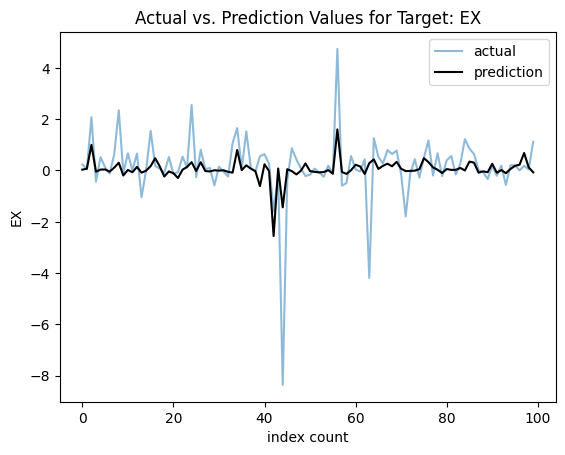

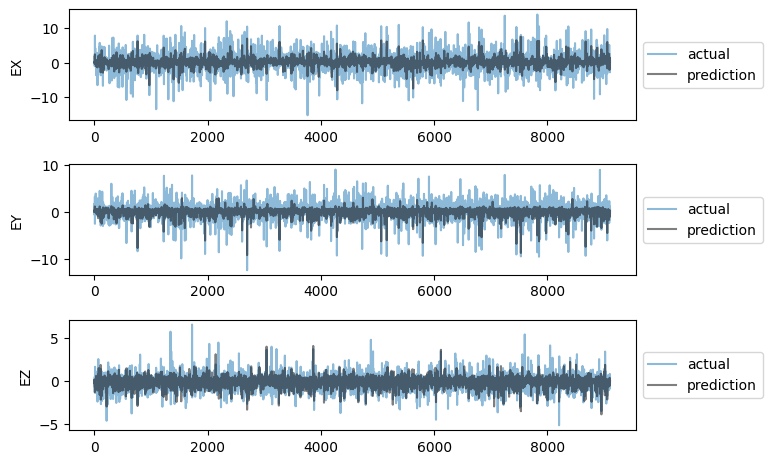

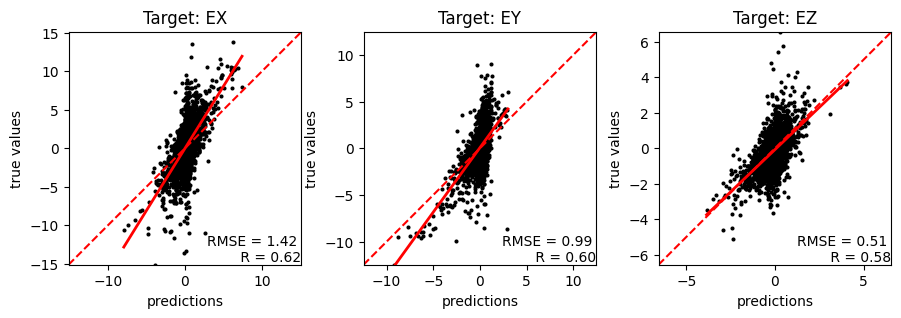

In [4]:
model.eval()
with torch.no_grad():

    preds = model(x_test_tensor).detach().numpy() # predictions (scaled)
    preds_descaled = y_scaler.inverse_transform(preds) # predictions (descaled)
    y_test_descaled = y_scaler.inverse_transform(y_test[:, -1, :]) # actual data (descaled)
    # y_out_inv = y_scaler.inverse_transform(preds)
    # y_test_inv = y_scaler.inverse_transform(y_test[:, 0])

    # target to plot
    target_indx = 0
    ix0 = 3000
    ixf = 3100

    # plot single target within index bounds of [ix0:ixf] (scale)
    viz.plot_single_pred_index(
        target[target_indx], 
        y_test[:, :, target_indx], 
        preds[:, target_indx],
        [ix0,ixf]

    )
    # plot all targets over index
    viz.plot_targets_overview(target, y_test_descaled, preds_descaled)

    # plot scatter plot of predicted vs. actual values with metrics
    viz.plot_preds_scatter(target, y_test_descaled, preds_descaled)

In [5]:
# evaluate on the test set (no MC dropout)
# set model to evaluation mode and deactivate autogradient engine
model.eval()
with torch.no_grad():
    predictions = model(x_test_tensor).detach().numpy()

    for i in range(CONFIG['output_size']):
        rmse = MCDO.rmse(y_test[:, 0, i], predictions[:, i])
        corr_coef, pvalue = scipy.stats.pearsonr(y_test[:, 0, i], predictions[:, i])
        print(f"RMSE for {target[i]}: {rmse:.4f}; R = {corr_coef:.4f}")

RMSE for EX: 1.0877; R = 0.6175
RMSE for EY: 0.9016; R = 0.6021
RMSE for EZ: 0.6489; R = 0.5839


# PULL DATA TESTING

In [17]:
from hapiclient import hapi

# t0 = "2015-09-01T00:00:00"
# tf = "2022-08-31T23:59:00"

# data server
# server = "https://cdaweb.gsfc.nasa.gov/hapi"

# # OMNI 1-minute dataset
# dataset = "OMNI_HRO2_1MIN"

# # The HAPI convention is that parameters is a comma-separated list. Here we request two parameters.
# omni_parameters = "IMF, BY_GSE, BZ_GSE,Vx,Vy,Vz,SYM_H"

# # Configuration options for the hapi function.
# opts = {"logging": True, "usecache": True, "cachedir": "./hapicache"}

# # Get parameter data. See section 5 for for information on getting available datasets and parameters
# omni_data, meta = hapi(server, dataset, omni_parameters, t0, tf, **opts)

# COMBINE DATA

# # create df to hold combined mms and omni datasets
# complete_df = mms_df.copy()

# # get var names from OMNI data in format that can be indexed
# omni_names = [s.strip() for s in omni_parameters.split(",")]

# create omni df
# omni_df = df = pd.DataFrame()

# add time column
# omni_df['time'] = omni_data['Time']

# # add variables
# for var in omni_names:
#     complete_df["OMNI_" + var] = omni_data[var]

from pymms.data import util, fpi, edi, fgm
import datetime as dt
from hapiclient import hapi

t0 = dt.datetime(2023, 4, 24, 16, 18, 0)
tf = dt.datetime(2023, 4, 25, 0, 0, 0)

def hapi_to_df(t0, tf):

    # create mother df
    df = pd.DataFrame()

    # %%% MMS data %%%

    # pull edi data using pymms
    mms_edi_data = edi.load_data(
        sc="mms1", 
        mode="srvy", 
        start_date=t0, 
        end_date=tf)

    # pull dis data using pymms
    dis_moms = fpi.load_moms(
        sc="mms1", 
        mode="srvy", 
        optdesc="dis-moms", 
        start_date=t0, 
        end_date=tf
    )
    
    # pull mec data using pymms
    mec_data = util.load_data(
        sc="mms1",
        instr="mec",
        mode="srvy",
        level="l2",
        optdesc="epht89d",
        start_date=t0,
        end_date=tf,
    )

    # # add time to df
    # df['mms_time'] = mms_edi_data["Epoch"]

    # # write mms data to df as individual coords
    # for xyz in ['x', 'y', 'z']:
    #     # add edi data to df
    #     df["E_DIS"+"_"+xyz.upper()] = mms_edi_data["E_GSE"].loc[:, "E"+xyz]

    # # average data into 1 min. bins
    # df = df.resample(rule="1Min", on="time").mean()

    # # # drop last row to account for OMNI dataset
    # mms_df = mms_df[:-1]

    # %%% OMNI data %%%

    # setup time in hapi input format
    t0_hapi = t0.strftime("%Y-%m-%d"+"T"+"%H:%M:%S")
    tf_hapi = tf.strftime("%Y-%m-%d" + "T" + "%H:%M:%S")
    print(t0_hapi) # check

    # hapi inputs
    server = "https://cdaweb.gsfc.nasa.gov/hapi"  # data server
    hapi_dataset = "OMNI_HRO2_1MIN"  # OMNI 1-minute dataset

    # params to download;
    #   - HAPI convention is that parameters is a comma-separated list
    omni_parameters = "IMF, BY_GSE, BZ_GSE,Vx,Vy,Vz,SYM_H" 

    # configuration options for the hapi function.
    opts = {"logging": True, "usecache": True, "cachedir": "./hapicache"}

    # pull omni data
    omni_data, meta = hapi(server, hapi_dataset, omni_parameters, t0_hapi, tf_hapi, **opts)

    # get var names from OMNI data in format that can be indexed
    omni_names = [s.strip() for s in omni_parameters.split(",")]

    # # add omni data to df
    # for var in omni_names:
    #     df["OMNI_" + var] = omni_data[var]

    # %%% CLEANING DATAFRAME %%%

    # # OMNI velcotiy has erroneous data where Vxyz values ~99999.9; removing those
    # omni_threshold = 90000
    # df[df["OMNI_Vx"] >= omni_threshold] = np.nan

    # drop rows with nans
    df.dropna(axis=0, inplace=True)

    return df

df_om =  hapi_to_df(t0, tf)

df_om

# [BI:06/13/2024]

2023-04-24T16:18:00
hapi(): Running hapi.py version 0.2.6
hapi(): file directory = ./hapicache/cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading OMNI_HRO2_1MIN_IMF,BY_GSE,BZ_GSE,Vx,Vy,Vz,SYM_H_20230424T161800_20230425T000000.pkl
hapi(): Reading OMNI_HRO2_1MIN_IMF,BY_GSE,BZ_GSE,Vx,Vy,Vz,SYM_H_20230424T161800_20230425T000000.npy 


""


In [ ]:
t0 = dt.datetime(2023, 4, 23, 0, 0, 0)
tf = dt.datetime(2023, 4, 25, 0, 0, 0)
mms_data = edi.load_data(sc="mms1", mode="srvy", start_date=t0, end_date=tf)
edi_ey = mms_data["E_GSE"].loc[:,'Ey']
edi_ey

<xarray.DataArray 'E_GSE' (Epoch: 1119)>
array([-0.25197494,  0.13307509,  1.083172  , ...,  0.296054  ,
        0.4260477 ,  0.7469831 ], dtype=float32)
Coordinates:
  * Epoch    (Epoch) datetime64[ns] 2023-04-24T16:18:42.702129920 ... 2023-04...
    E_index  <U2 'Ey'
Attributes: (12/16)
    cdf_name:       mms1_edi_e_gse_srvy_l2
    cdf_type:       CDF_FLOAT
    rec_vary:       1
    CATDESC:        Electric field in GSE coordinates.
    DELTA_PLUS:     mms1_edi_e_gse_delta_plus_srvy_l2
    DELTA_MINUS:    mms1_edi_e_gse_delta_minus_srvy_l2
    ...             ...
    SCALETYP:       linear
    SI_CONVERSION:  1e-3>V/m
    units:          mV/m
    VALIDMIN:       -10000.0
    VALIDMAX:       10000.0
    VAR_TYPE:       data

In [12]:
dis_moms = fpi.load_moms(
        sc="mms1", 
        mode="srvy", 
        optdesc="dis-moms", 
        start_date=t0, 
        end_date=tf
    )

# Distribution functions
dis_dist = fpi.load_dist(
    sc="mms1", mode="srvy", optdesc="dis-dist", start_date=t0, end_date=tf
)

dis_moms

def get_dis_efield(t0,tf):
    df_dis_efield = pd.DataFrame()

    # %%% DIS %%%

    # pull fpi dis data
    dis_moms = fpi.load_moms(
        sc="mms1", 
        mode="srvy", 
        optdesc="dis-moms", 
        start_date=t0, 
        end_date=tf
    )

    # get dis bulk velcotiy V with units [km/s]
    mms_dis_vel = dis_moms["mms1_dis_bulkv_gse_fast"]
    mms_dis_vel_names = dis_moms["mms1_dis_bulkv_gse_labels_fast"].values

    

    mms_bfield_data = fgm.load_data(sc="mms1", 
                                    mode="srvy", 
                                    start_date=t0, 
                                    end_date=tf)

    # get fgm b-field data

    # get FGM magnetic field B with units [nT]

    # compute the cross product for each point using numpy.cross
    # multiply by factor of 1e-9 to convert to units [mV/m]
    instr_label = 'DIS_'
    # df_ds[['DIS_EX','DIS_EY','DIS_EZ']] = -1 * np.cross(df_ds[vcols], df_ds[bcols])

    return df_dis_efield


# get_dis_efield

dis_moms

<xarray.Dataset>
Dimensions:                                  (time: 2957,
                                              mms1_dis_compressionloss_fast: 1,
                                              energy_index: 32,
                                              delta energy: 32,
                                              velocity_index: 3,
                                              mms1_dis_bulkv_err_label_fast: 3,
                                              ...
                                              mms1_dis_bulkv_gse_label_fast: 3,
                                              mms1_dis_bulkv_spintone_gse_label_fast: 3,
                                              cart_index_dim2: 3,
                                              heatflux_index: 3,
                                              mms1_dis_heatq_err_label_fast: 3,
                                              mms1_dis_heatq_gse_label_fast: 3)
Coordinates: (12/15)
    Epoch_plus_var                           timedelta64[ns] 00:00:02.249999872
    Epoch_minus_var                          timedelta64[ns] 00:00:02.249999872
  * mms1_dis_compressionloss_fast            (mms1_dis_compressionloss_fast) uint8 ...
    energy                                   (time, energy_index) float32 2.1...
  * velocity_index                           (velocity_index) <U7 'Vx_DBCS' ....
  * mms1_dis_bulkv_err_label_fast            (mms1_dis_bulkv_err_label_fast) <U6 ...
    ...                                       ...
  * mms1_dis_bulkv_spintone_gse_label_fast   (mms1_dis_bulkv_spintone_gse_label_fast) <U15 ...
    cart_index_dim2                          (cart_index_dim1) <U1 'x' 'y' 'z'
  * heatflux_index                           (heatflux_index) <U7 'Qx_DBCS' ....
  * mms1_dis_heatq_err_label_fast            (mms1_dis_heatq_err_label_fast) <U6 ...
  * mms1_dis_heatq_gse_label_fast            (mms1_dis_heatq_gse_label_fast) <U6 ...
  * time                                     (time) datetime64[ns] 2023-04-24...
Dimensions without coordinates: energy_index, delta energy
Data variables: (12/36)
    mms1_dis_errorflags_fast                 (time) uint32 0 0 0 ... 8192 8192
    mms1_dis_startdelphi_count_fast          (time) uint16 2400 3718 ... 4343
    mms1_dis_startdelphi_angle_fast          (time) float32 150.0 ... 271.4
    mms1_dis_energy_delta_fast               (time, delta energy) float32 0.8...
    mms1_dis_energyspectr_px_fast            (time, energy_index) float32 0.0...
    mms1_dis_energyspectr_mx_fast            (time, energy_index) float32 5.6...
    ...                                       ...
    mms1_dis_heatq_err_fast                  (time, mms1_dis_heatq_err_label_fast) float32 ...
    mms1_dis_heatq_gse_fast                  (time, mms1_dis_heatq_gse_label_fast) float32 ...
    temppara                                 (time) float32 28.74 ... 731.9
    tempperp                                 (time) float32 53.36 ... 643.2
    t                                        (time) float32 45.15 ... 672.8
    p                                        (time) float32 0.01321 ... 1.445
Attributes: (12/50)
    filename:                             /Users/bisola/data/mms/mms1/fpi/fas...
    Project:                              ['STP>Solar-Terrestrial Physics']
    Source_name:                          ['MMS1>MMS Satellite Number 1']
    Discipline:                           ['Space Physics>Magnetospheric Scie...
    Data_type:                            ['fast_l2_dis-moms']
    Descriptor:                           ['DIS>Dual Ion Spectrometers']
    ...                                   ...
    sc:                                   mms1
    instr:                                fpi
    mode:                                 fast
    level:                                l2
    optdesc:                              dis-moms
    files:                                ['/Users/bisola/data/mms/mms1/fpi/f...

In [26]:
mms_fgm_data = fgm.load_data(
    sc="mms1", 
    mode="srvy", 
    start_date=t0, 
    end_date=tf)

mms_fgm_data["B_GSE"].loc[:, "x"]

<xarray.DataArray 'B_GSE' (time: 443226)>
array([  31.187672,   31.172813,   31.148638, ..., -148.7666  ,
       -148.77432 , -148.80328 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2023-04-24T16:18:00.008554657 ... 2023-04-...
    b_index  <U1 'x'
Attributes: (12/17)
    cdf_name:           mms1_fgm_b_gse_srvy_l2
    cdf_type:           CDF_REAL4
    rec_vary:           1
    CATDESC:            Magnetic field vector in Geocentric Solar Ecliptic (G...
    DISPLAY_TYPE:       time_series
    FIELDNAM:           Magnetic field vector in GSE plus Btotal (8 or 16 S/s)
    ...                 ...
    VAR_TYPE:           data
    SCALETYP:           linear
    COORDINATE_SYSTEM:  GSE
    SI_CONVERSION:      1.0e-9>T
    TENSOR_ORDER:       1
    REPRESENTATION_1:   represent_vec_tot

In [38]:
# pull fpi dis data
dis_moms = fpi.load_moms(
    sc="mms1", 
    mode="srvy", 
    optdesc="dis-moms", 
    start_date=t0, 
    end_date=tf
)

# get dis bulk velcotiy V with units [km/s]
mms_dis_vel = dis_moms["mms1_dis_bulkv_gse_fast"].loc[:,"Vx"]
mms_dis_vel

KeyError: "not all values found in index 'mms1_dis_bulkv_gse_label_fast'. Try setting the `method` keyword argument (example: method='nearest')."

# EFIELD MAPS

In [ ]:
# inputs t0, te, imef_data
# assume nans removed
import xarray as xr

imef_data = pd.read_pickle("prop_models/complete_training_df")
symh_data = imef_data["OMNI_SYM_H"].to_xarray() # update to xr to use 'sel' func
time_indx = imef_data.index.values

design_matrix = []  # list to hold desigh matrix
time_matrix = []  # list to hold times assoc. with matrix values

ft = 60*5

# imef_data.where(imef_data.index>=(imef_data.index.values[0]+np.timedelta64(5, 'h')), drop=True)
targ_list = ["OMNI_IMF", "OMNI_Vx", "OMNI_Vy", "OMNI_Vz", "OMNI_SYM_H"]

for ix in range(0,len(time_indx)):
    ix_matrix_row = [] # matrix row at loop index (ix)

    # get time intervals
    # `- (!) should be end
    time_intervals = pd.date_range(start=time_indx[ix], freq="5T", periods=60)
    # print('index',time_indx)
    # print('intrvl',time_intervals)
    # try:
    # write predictors at ix to row

    for given_targ in targ_list:
        tarr = imef_data[given_targ].to_xarray()

        ix_targ = tarr.sel(time=time_intervals, method='nearest').values.tolist()
        ix_matrix_row += ix_targ # append to design matrix row

    # ix_symh = symh_data.sel(time=time_intervals, method='nearest').values.tolist()
    # ix_matrix_row += ix_symh # append to design matrix row

    # get location data (L, MLT, MLAT)
    loc_data = np.array(
        [imef_data["L"].values[ix],
        np.cos(np.pi / 12 * imef_data["MLT"].values[ix]),
        np.sin(np.pi / 12 * imef_data["MLT"].values[ix]),
        np.cos(imef_data["MLAT"].values[ix]),
        np.sin(imef_data["MLAT"].values[ix]),]
    )

    # write location data (np array) at ix to row (list)
    ix_matrix_row += loc_data.tolist()

    # append row to design matrix
    # print("row",ix_matrix_row)
    design_matrix.append(ix_matrix_row)

    # append times to time matrix
    time_matrix.append(time_indx[ix])

# torch tensor design matrix
design_matrix_tensor = torch.tensor(design_matrix)

# except Exception as ex:
#     pass

In [ ]:
base_symh = design_matrix_tensor[-1].clone()
number_of_inputs = len(targ_list)
size_of_input_vector = 60 * number_of_inputs + 5

for L in range(4, 11):
    for MLT in range(0, 24):
        new_row = base_symh.clone()
        new_row[-3] = L
        new_row[-2] = np.cos(np.pi / 12 * MLT)
        new_row[-1] = np.sin(np.pi / 12 * MLT)
        even_newer_row = torch.empty((1, size_of_input_vector))
        even_newer_row[0] = new_row
        if L == 4 and MLT == 0:
            all_locations = even_newer_row
        else:
            all_locations = torch.cat((all_locations, even_newer_row))

model.eval()
with torch.no_grad():
    pred = model(all_locations)

RuntimeError: shape '[168, 420]' is invalid for input of size 51240

In [ ]:
l = ["Geeks", "for", "Geeks!"]

# open file
with open("gfg.txt", "w+") as f:

    # write elements of list
    for items in l:
        f.write("%s\n" % items)

    print("File written successfully")


# close the file
f.close()

File written successfully


In [ ]:
hidden_size_arr = [[5000, 1000, 500, 100, 15], [1000, 500, 100, 15], [1000, 100, 15]]
for i in hidden_size_arr:
    print(str(i[-1]))
    i[-1]


seq_len = 60
bsize = 32
dropout_prob = 0.2
num_epochs = 1000
patience = 20


hidden_size_arr = [[5000, 1000, 500, 100, 15], [1000, 500, 100, 15], [1000, 100, 15]]
learning_rate_arr = [1e-2, 1e-4, 5e-4, 1e5, 1e-6]



15
15
15
